In [59]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import time
import os

# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
x_train.shape # (50000, 32, 32, 3)
y_train.shape # (50000, 1)

(50000, 1)

In [4]:
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

In [5]:
id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}
print(id2class)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [6]:
def display_cifar_images(
    x: np.ndarray,
    y: np.ndarray,
    id2class: dict[int, str],
    n: int = 4
):
    random_images_indices = np.random.randint(0, x.shape[0], n)
    images = x[random_images_indices]
    classes = [id2class[y[idx, 0]] for idx in random_images_indices]


    f, axs = plt.subplots(1, n, figsize=((3*n, 3)))
    for image, name, ax in zip(images, classes, axs):
        ax.imshow(image)
        ax.axis('off')
        ax.set(title=f"Class: {name}")
    plt.show()

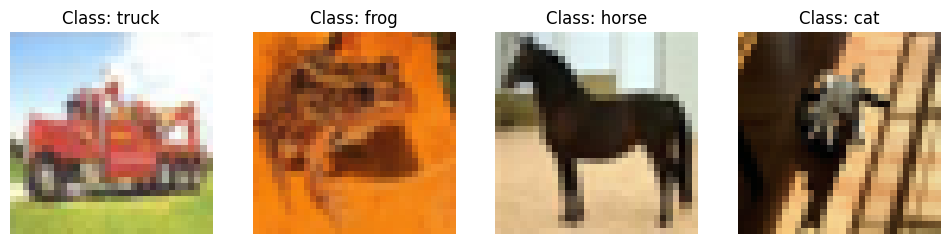

In [7]:
display_cifar_images(x_train, y_train, id2class)

In [8]:
class NNClassifier(tf.keras.Model):
    """Image classifier with fully-connected layers"""
    def __init__(self, hidden_dim: int, n_classes: int, *args, **kwargs):
        super(NNClassifier, self).__init__(*args, **kwargs) # ініціалізація супер класу є обов'язкова!


        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.out = tf.keras.layers.Dense(n_classes,activation='softmax') # можна додати activation = 'softmax'

    def call(self, inputs, training: bool):
        x = self.flatten(inputs)
        x = self.dense2(self.dense1(x))
        return self.out(x)

model = NNClassifier(hidden_dim=100, n_classes=len(id2class))


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # спарс версія оскільки y_train та y_test містять номери класів
    # /loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [10]:
start_time = time.time()


hist = model.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_test, y_test)
)

end_time = time.time()


Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 2.0319 - accuracy: 0.2625 - val_loss: 1.9026 - val_accuracy: 0.3171
Epoch 2/100
391/391 [==============================] - 1s 3ms/step - loss: 1.8466 - accuracy: 0.3490 - val_loss: 1.8045 - val_accuracy: 0.3610
Epoch 3/100
391/391 [==============================] - 1s 3ms/step - loss: 1.7792 - accuracy: 0.3740 - val_loss: 1.7525 - val_accuracy: 0.3810
Epoch 4/100
391/391 [==============================] - 1s 3ms/step - loss: 1.7298 - accuracy: 0.3903 - val_loss: 1.7064 - val_accuracy: 0.4021
Epoch 5/100
391/391 [==============================] - 1s 3ms/step - loss: 1.6906 - accuracy: 0.4042 - val_loss: 1.6846 - val_accuracy: 0.4039
Epoch 6/100
391/391 [==============================] - 1s 3ms/step - loss: 1.6579 - accuracy: 0.4170 - val_loss: 1.6455 - val_accuracy: 0.4204
Epoch 7/100
391/391 [==============================] - 1s 3ms/step - loss: 1.6293 - accuracy: 0.4259 - val_loss: 1.6140 - val_accuracy: 0.4303

In [11]:
model.summary()

Model: "nn_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  307300    
                                                                 
 dense_1 (Dense)             multiple                  10100     
                                                                 
 dense_2 (Dense)             multiple                  1010      
                                                                 
Total params: 318410 (1.21 MB)
Trainable params: 318410 (1.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# hist.history

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
test_loss, test_acc

313/313 [==============================] - 0s 954us/step - loss: 1.3682 - accuracy: 0.5300


(1.3681836128234863, 0.5299999713897705)

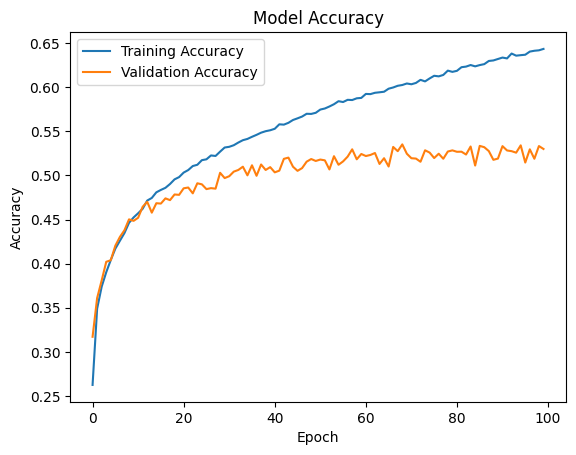

In [14]:
# Plot accuracy per epoch
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

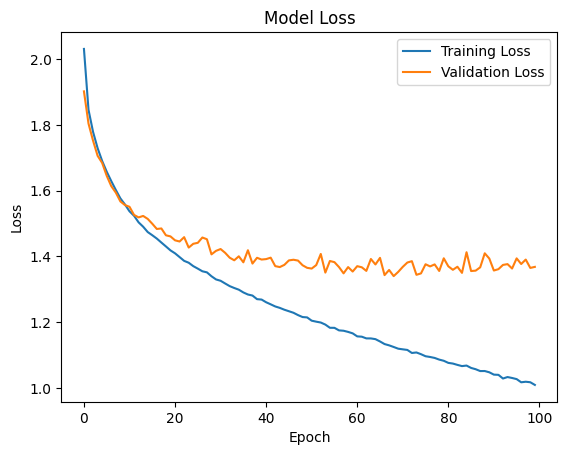

In [15]:
# Plot loss per epoch
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

По графіках loss та accuracy, видно що модель перетренувалась на train даних

In [16]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

313/313 [==============================] - 0s 850us/step


In [17]:
cm = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(cm)

cr = classification_report(y_test, predicted_classes)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[534  33  70  36  29   7  17  36 170  68]
 [ 32 610  17  20   7   8  12  27  80 187]
 [ 64  18 437 100 105  68  82  73  25  28]
 [ 25  12  87 407  59 153  99  64  42  52]
 [ 42  10 162  83 413  39  91 102  41  17]
 [ 12   7  85 237  67 368  56 102  31  35]
 [  8  19  86 105  81  38 583  27  25  28]
 [ 31  14  55  72  59  55  24 610  25  55]
 [ 62  55  16  26  22   8   3  13 729  66]
 [ 26 161  18  40   8  13  14  51  60 609]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      1000
           1       0.65      0.61      0.63      1000
           2       0.42      0.44      0.43      1000
           3       0.36      0.41      0.38      1000
           4       0.49      0.41      0.45      1000
           5       0.49      0.37      0.42      1000
           6       0.59      0.58      0.59      1000
           7       0.55      0.61      0.58      1000
           8       0.59      0.73      0.

Автоматизуємо процес виведення пар класів які плутаються(беру ті, які мають більше за 100)
Виводимо пари, а потім маючи словник ключ-значення виводимо назви



In [47]:
def true_upper_triangle_indexes(matrix):
    """
    Find the indexes of 'True' values in the upper triangle of the matrix,
    excluding the diagonal.

    :param matrix: 2D NumPy array representing the matrix of boolean values
    :return: List of tuples where each tuple represents the (row, column) index of a 'True' value
    """

    true_indices = np.argwhere(matrix>100)


    upper_triangle_indices = [(i, j) for i, j in true_indices if i < j]

    return upper_triangle_indices

print(true_upper_triangle_indexes(cm))
print([(id2class[i], id2class[j]) for i, j in true_upper_triangle_indexes(cm)])

[(0, 8), (1, 9), (2, 4), (3, 5), (4, 7), (5, 7)]
[('airplane', 'ship'), ('automobile', 'truck'), ('bird', 'deer'), ('cat', 'dog'), ('deer', 'horse'), ('dog', 'horse')]


Щодо метрик: найкраще себе показує клас 8, а найгірше 3 чи 5, датасет збалансований загалом, значення точностей не найкращі

Також видно що середнє відхилення recall вище за precision, але не знаю які це висновки дає, враховуючи що датасет збалансовний

In [18]:
model.save('my_model')

model_size = os.path.getsize('my_model')
print("Model size: {:.2f} bytes".format(model_size))

del(model)

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


Model size: 4096.00 bytes


видно що стандартне оприділення розміру моделі через обʼєм папки на диску не працює, тому будемо користуватись даними з методу model.summary()


In [19]:
model = load_model('my_model')
test_loss, test_acc = model.evaluate(x_test, y_test)
test_loss, test_acc

313/313 [==============================] - 0s 1ms/step - loss: 1.3682 - accuracy: 0.5300


(1.3681836128234863, 0.5299999713897705)

In [20]:
training_time = end_time - start_time
print("Training time: {:.2f} seconds".format(training_time))


Training time: 114.21 seconds


# Modifing model with changed hyperparams



In [21]:
class NNClassifier1(tf.keras.Model):
    """Image classifier with fully-connected layers"""
    def __init__(self, hidden_dim: int, n_classes: int, *args, **kwargs):
        super(NNClassifier1, self).__init__(*args, **kwargs) # ініціалізація супер класу є обов'язкова!


        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense4 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dense5 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.out = tf.keras.layers.Dense(n_classes,activation='softmax') # можна додати activation = 'softmax'

    def call(self, inputs, training: bool):
        x = self.flatten(inputs)
        x = self.dense5(self.dense4(self.dense3(self.dense2(self.dense1(x)))))
        return self.out(x)

model1 = NNClassifier1(hidden_dim=1000, n_classes=len(id2class))


In [22]:
model1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    # спарс версія оскільки y_train та y_test містять номери класів
    # /loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [23]:
start_time1 = time.time()


hist1 = model1.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    validation_data=(x_test, y_test)
)


end_time1 = time.time()

Epoch 1/100
391/391 [==============================] - 8s 19ms/step - loss: 2.0425 - accuracy: 0.2656 - val_loss: 1.8709 - val_accuracy: 0.3356
Epoch 2/100
391/391 [==============================] - 7s 18ms/step - loss: 1.8011 - accuracy: 0.3613 - val_loss: 1.7747 - val_accuracy: 0.3742
Epoch 3/100
391/391 [==============================] - 7s 18ms/step - loss: 1.7082 - accuracy: 0.3938 - val_loss: 1.6511 - val_accuracy: 0.4137
Epoch 4/100
391/391 [==============================] - 7s 18ms/step - loss: 1.6432 - accuracy: 0.4147 - val_loss: 1.6104 - val_accuracy: 0.4239
Epoch 5/100
391/391 [==============================] - 7s 18ms/step - loss: 1.5941 - accuracy: 0.4332 - val_loss: 1.5651 - val_accuracy: 0.4441
Epoch 6/100
391/391 [==============================] - 7s 18ms/step - loss: 1.5497 - accuracy: 0.4499 - val_loss: 1.5434 - val_accuracy: 0.4489
Epoch 7/100
391/391 [==============================] - 7s 18ms/step - loss: 1.5113 - accuracy: 0.4657 - val_loss: 1.5182 - val_accuracy:

In [24]:
model1.summary()

Model: "nn_classifier1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  3073000   
                                                                 
 dense_4 (Dense)             multiple                  1001000   
                                                                 
 dense_5 (Dense)             multiple                  1001000   
                                                                 
 dense_6 (Dense)             multiple                  1001000   
                                                                 
 dense_7 (Dense)             multiple                  1001000   
                                                                 
 dense_8 (Dense)             multiple               

In [25]:
test_loss, test_acc = model1.evaluate(x_test, y_test)
test_loss, test_acc

313/313 [==============================] - 2s 5ms/step - loss: 2.8545 - accuracy: 0.5506


(2.854487180709839, 0.550599992275238)

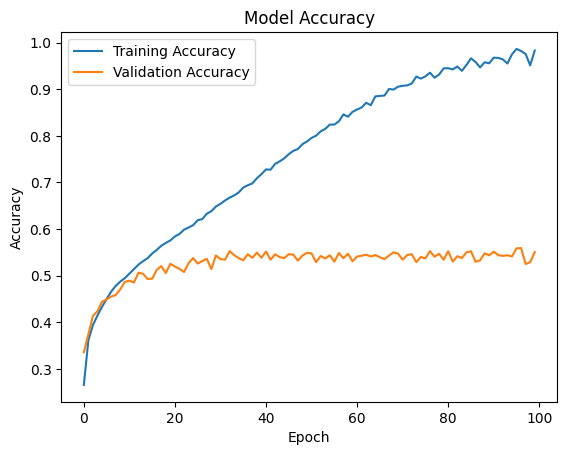

In [26]:
# Plot accuracy per epoch
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

серйозний оверфіт

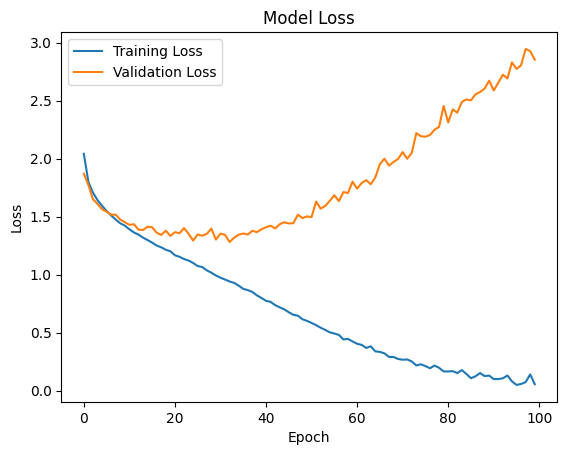

In [27]:
# Plot accuracy per epoch
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
predictions1 = model1.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

313/313 [==============================] - 2s 5ms/step


In [29]:
cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
print(cm1)

cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

Confusion Matrix:
[[634  45  41  31  22  16  24  14 118  55]
 [ 30 704  13  28   7  11  17  10  60 120]
 [ 97  17 386 122  89  67 113  46  31  32]
 [ 21  39  69 440  43 145 128  36  32  47]
 [ 49  16 113  99 432  57 126  59  32  17]
 [ 21  10  61 280  52 421  58  48  28  21]
 [ 14  27  45 111  64  27 663  11  17  21]
 [ 48  19  48  85  85  68  37 533  14  63]
 [ 88  90  12  28  20   5  12   6 685  54]
 [ 39 189  13  35   9  19  15  17  56 608]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62      1000
           1       0.61      0.70      0.65      1000
           2       0.48      0.39      0.43      1000
           3       0.35      0.44      0.39      1000
           4       0.52      0.43      0.47      1000
           5       0.50      0.42      0.46      1000
           6       0.56      0.66      0.60      1000
           7       0.68      0.53      0.60      1000
           8       0.64      0.69      0.

In [48]:
def true_upper_triangle_indexes(matrix):
    """
    Find the indexes of 'True' values in the upper triangle of the matrix,
    excluding the diagonal.

    :param matrix: 2D NumPy array representing the matrix of boolean values
    :return: List of tuples where each tuple represents the (row, column) index of a 'True' value
    """
    true_indices = np.argwhere(matrix>100)


    upper_triangle_indices = [(i, j) for i, j in true_indices if i < j]

    return upper_triangle_indices

print(true_upper_triangle_indexes(cm))
print([(id2class[i], id2class[j]) for i, j in true_upper_triangle_indexes(cm)])

[(0, 8), (1, 9), (2, 4), (3, 5), (4, 7), (5, 7)]
[('airplane', 'ship'), ('automobile', 'truck'), ('bird', 'deer'), ('cat', 'dog'), ('deer', 'horse'), ('dog', 'horse')]


змін майже не відбулось, висновки ті самі

In [38]:
model1.save('my_model1')


model_size1 = os.path.getsize('my_model1')
print("Model size: {} bytes".format(model_size1))

#del(model1)

AttributeError: 'int' object has no attribute 'save'

In [49]:
model1 = load_model('my_model1')
test_loss, test_acc = model1.evaluate(x_test, y_test)
test_loss, test_acc

313/313 [==============================] - 2s 5ms/step - loss: 2.7533 - accuracy: 0.5506


(2.7532806396484375, 0.550599992275238)

In [32]:
training_time1 = end_time1 - start_time1
print("Training time: {:.2f} seconds".format(training_time1))


Training time: 713.57 seconds


In [33]:
diff_time = training_time1 - training_time
print("Dirrefence between time training: {:.2f} seconds".format(diff_time))


Dirrefence between time training: 599.36 seconds


In [34]:
model_size1, model_size

(4096, 4096)

оприділення розміру через фізичний розмір на диску не працює, бо можливо це команда бере чисто розмір папки, а не те що всередині, тому маємо дефолтні 4кб резерву під директорію, тоді спробуємо інакше: за визначенням мережі)

Model Size in Bytes
=
Total Number of Parameters
×
Bytes per Parameter
Model Size in Bytes=Total Number of Parameters×Bytes per Parameter


In [35]:
model=318410*4
model/1024/1024


1.2146377563476562

In [37]:
model1=7087010 *4
model1/1024/1024

27.03479766845703

In [54]:
def preprocess_image(image_path, target_size=(32, 32)):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)
    image = image / 255.0
    return image

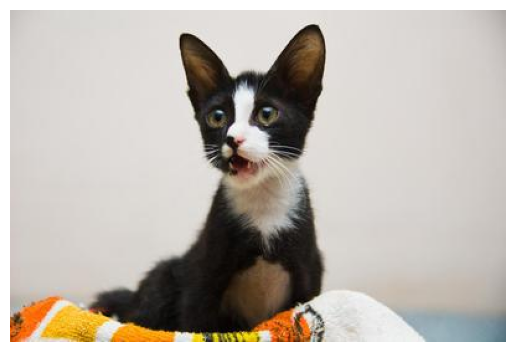

1/1 [==============================] - 0s 16ms/step
[[1.8950035e-03 3.9848307e-04 1.1849804e-04 6.3846070e-01 1.0041987e-01
  1.8040548e-05 2.8417462e-05 2.0083237e-01 5.3107116e-02 4.7215372e-03]]
3
cat


In [60]:
image_path = './1.jpg'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
preprocessed_image = preprocess_image(image_path)
predictions = model1.predict(preprocessed_image)
print(predictions)
print(np.argmax(predictions))
print(id2class[np.argmax(predictions)])

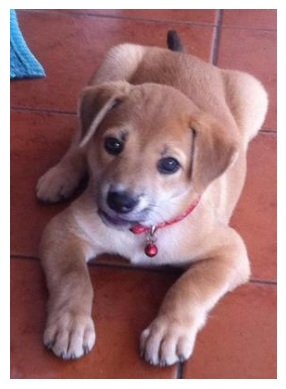

1/1 [==============================] - 0s 16ms/step
[[2.6886363e-07 7.7432089e-11 5.0705233e-07 6.9778383e-01 4.8420796e-09
  1.2173494e-03 3.0099764e-01 3.3262535e-07 1.8436312e-10 3.0009026e-08]]
3
cat


In [61]:
image_path = './2.jpg'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
preprocessed_image = preprocess_image(image_path)
predictions = model1.predict(preprocessed_image)
print(predictions)
print(np.argmax(predictions))
print(id2class[np.argmax(predictions)])

1 рисунок ок, але на 2 рисунку точно не кіт), але і модель у нас давала тільки 52% для цього класу